In [198]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
import geopandas
import os
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import networkx as nx
import pandas as pd

from utils import load_eurostat_data

plt.rcParams["figure.figsize"] = (20,15)
plt.rc('font', size=12)

In [200]:
EU28 = [
    'AT', 'BE', 'BG',
    'CZ', 'DE', 'DK',
    'EE', 'GR', 'ES', 
    'FI', 'FR', 'HR', 
    'UK',
    'HU', 'IE', 'IT', 'LT', 'LU', 'LV',
    'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK',
]

<AxesSubplot:>

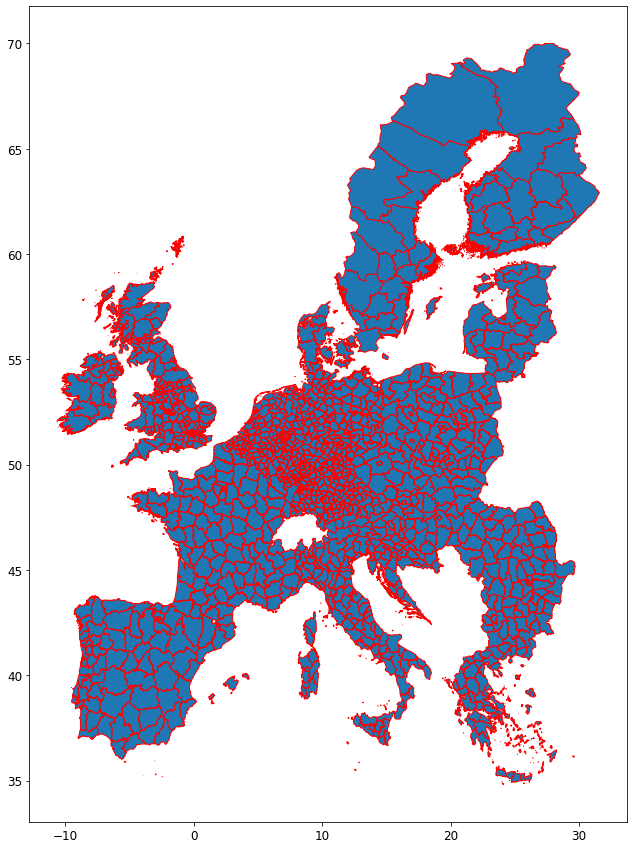

In [203]:
file = "NUTS_RG_01M_2016_4326.shp.zip"
states =geopandas.read_file(os.path.join(file)).to_crs("EPSG:4326")
states =states[states["LEVL_CODE"]==3]
polygon = Polygon([(-12, 28), (50, 28), (50, 70), (-12, 70), (-12, 28)])
states_clip = states.clip(polygon)
states_clip = states_clip[(states_clip["CNTR_CODE"].isin(EU28+["GB","EL"]))]
states_clip.plot(edgecolor="r")

In [204]:
df=pd.DataFrame()
df["area_code"] = states_clip["NUTS_ID"]
df["area"]=states_clip.area
df

C:\Users\czhou\AppData\Local\Temp\ipykernel_34244\1430541321.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df["area"]=states_clip.area


,area_code,area
1119,EL421,0.272472
1110,EL412,0.079681
561,BG343,0.366297
537,BG341,0.848881
560,BG342,0.389142
...,...,...
1138,ES418,0.876354
637,ES511,0.836533
1148,ES243,1.865971
1640,PT111,0.240646


In [189]:
# NUTS_ID = states_clip["NUTS_ID"].unique()
# x= set(demo["geo\\time"])
# y= set(NUTS_ID)


In [205]:
demo = load_eurostat_data("demo_r_d3dens.tsv")
# demo = demo[demo["geo\\time"].isin(NUTS_ID)]
demo = demo[["geo\\time", "unit", "2018","2017"]]
demo = demo.rename(columns={"geo\\time":"area_code"})
demo = demo.merge(df,on="area_code")
demo["countryKey"] = demo["area_code"].str[0:2]
demo["population"] = (demo["2018"] + demo["2017"])*demo["area"]
demo_1 = demo.groupby("countryKey").sum().reset_index()
demo.loc[demo["countryKey"]=="EL", "countryKey"]="GR"
demo.loc[demo["countryKey"]=="BE", "countryKey"]="BE-LU"
demo.loc[demo["countryKey"]=="LU", "countryKey"]="BE-LU"
demo.loc[demo["countryKey"]=="DK", "countryKey"]="DK-SE"
demo.loc[demo["countryKey"]=="SE", "countryKey"]="DK-SE"
demo.loc[demo["countryKey"]=="LV", "countryKey"]="LV-EE"
demo.loc[demo["countryKey"]=="EE", "countryKey"]="LV-EE"
demo

,area_code,unit,2018,2017,area,countryKey,population
0,AT111,PER_KM2,54.2,54.3,0.084011,AT,9.115213
1,AT112,PER_KM2,96.9,103.1,0.215419,AT,43.083747
2,AT113,PER_KM2,66.9,67.2,0.174392,AT,23.385937
3,AT121,PER_KM2,74.6,74.4,0.405402,AT,60.404891
4,AT122,PER_KM2,77.7,77.4,0.405168,AT,62.841570
...,...,...,...,...,...,...,...
1326,UKN12,PER_KM2,72.6,72.5,0.279112,UK,40.499205
1327,UKN13,PER_KM2,248.7,247.7,0.101401,UK,50.335550
1328,UKN14,PER_KM2,284.6,281.8,0.070756,UK,40.076247
1329,UKN15,PER_KM2,130.8,130.4,0.146848,UK,38.356703


In [206]:
demo_1 = demo.groupby("countryKey").sum().reset_index()[["countryKey", "population"]]
demo_1 = demo_1.rename(columns={"population":"region_population"})
demo = demo.merge(demo_1,on="countryKey", how="outer")
# population_weight is the population percentage of this area to the whole region
demo["pop_weight"] = demo["population"]/demo["region_population"]
demo

,area_code,unit,2018,2017,area,countryKey,population,region_population,pop_weight
0,AT111,PER_KM2,54.2,54.3,0.084011,AT,9.115213,2177.478733,0.004186
1,AT112,PER_KM2,96.9,103.1,0.215419,AT,43.083747,2177.478733,0.019786
2,AT113,PER_KM2,66.9,67.2,0.174392,AT,23.385937,2177.478733,0.010740
3,AT121,PER_KM2,74.6,74.4,0.405402,AT,60.404891,2177.478733,0.027741
4,AT122,PER_KM2,77.7,77.4,0.405168,AT,62.841570,2177.478733,0.028860
...,...,...,...,...,...,...,...,...,...
1326,UKN12,PER_KM2,72.6,72.5,0.279112,UK,40.499205,17711.163424,0.002287
1327,UKN13,PER_KM2,248.7,247.7,0.101401,UK,50.335550,17711.163424,0.002842
1328,UKN14,PER_KM2,284.6,281.8,0.070756,UK,40.076247,17711.163424,0.002263
1329,UKN15,PER_KM2,130.8,130.4,0.146848,UK,38.356703,17711.163424,0.002166


In [207]:
states_clip = states_clip.merge(demo, left_on="NUTS_ID", right_on="area_code")

In [208]:
states_clip.to_file(os.path.join("eu_region_3","eu_region_3.shp"))

C:\Users\czhou\anaconda3\envs\gas\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\czhou\AppData\Local\Temp\ipykernel_34244\1587783709.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  states_clip.to_file(os.path.join("eu_region_3","eu_region_3.shp"))


In [194]:
saved =geopandas.read_file(os.path.join("eu","eu_region_3.shp")).to_crs("EPSG:4326")


In [195]:
saved

,LEVL_CODE,NUTS_ID,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,area_code,unit,2018,2017,area,countryKey,population,region_pop,pop_weight,geometry
0,3,BG343,BG,Yambol,?????,4,2,3,BG343,BG343,PER_KM2,35.8,36.4,0.366297,BG,26.446652,1569.745333,0.016848,"POLYGON ((26.72027 42.68116, 26.71844 42.67479..."
1,3,BG341,BG,Burgas,??????,4,2,1,BG341,BG341,PER_KM2,53.8,54.0,0.848881,BG,91.509318,1569.745333,0.058296,"MULTIPOLYGON (((27.88613 42.81539, 27.90081 42..."
2,3,BG342,BG,Sliven,??????,2,2,3,BG342,BG342,PER_KM2,53.2,53.7,0.389142,BG,41.599282,1569.745333,0.026501,"POLYGON ((26.56949 42.98010, 26.56977 42.97545..."
3,3,BG331,BG,Varna,?????,4,2,1,BG331,BG331,PER_KM2,124.9,125.0,0.423218,BG,105.762302,1569.745333,0.067375,"POLYGON ((27.43970 43.58454, 27.43975 43.58454..."
4,3,BG334,BG,Targovishte,?????????,4,3,3,BG334,BG334,PER_KM2,41.5,41.9,0.300379,BG,25.051635,1569.745333,0.015959,"POLYGON ((26.73346 43.40988, 26.74153 43.40799..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,3,ES418,ES,Valladolid,Valladolid,4,2,3,ES418,ES418,PER_KM2,64.3,64.5,0.876354,ES,112.874422,9496.124132,0.011886,"MULTIPOLYGON (((-5.00594 42.28110, -5.00649 42..."
1275,3,ES511,ES,Barcelona,Barcelona,2,1,1,ES511,ES511,PER_KM2,718.7,712.2,0.836533,ES,1196.995147,9496.124132,0.126051,"MULTIPOLYGON (((2.74792 41.64316, 2.72794 41.6..."
1276,3,ES243,ES,Zaragoza,Zaragoza,2,1,3,ES243,ES243,PER_KM2,56.3,56.1,1.865971,ES,209.735135,9496.124132,0.022086,"POLYGON ((0.32136 41.39365, 0.34135 41.38163, ..."
1277,3,PT111,PT,Alto Minho,Alto Minho,2,3,1,PT111,PT111,PER_KM2,105.9,106.5,0.240646,PT,51.113205,2085.127317,0.024513,"POLYGON ((-8.16913 41.80820, -8.18335 41.81162..."
